# Analysis of Wind Turbine Data with Generalized Additive Models for Location, Scale, and Shape (R Package Gamlss)

1. [Libraries and external scripts.](#Cell1)
1. [Load the data frame.](#Cell2)
1. [Add columns with horizontal wind velocity magnitudes and remove columns with velocity components.](#Cell3)
1. [Examine autocorrelations in turbine output measurements.](#Cell4)
1. [Create new data frames, one per turbine output; split each data frame into a training and a testing data frame.](#Cell5)
1. [Fit training data frames.](#Cell6)
1. [Fit training data frames, this time eliminating predictors that are not significant.](#Cell7)
1. [Compute root mean squared errors on training and testing data sets.](#Cell8)
1. [Print summary of fit results by turbine.](#Cell9)
1. [Make a QQ plot.](#Cell10)
1. [Plot residuals.](#Cell11)
1. [Make a worm plot.](#Cell12)
1. [Fit entire training data set.](#Cell13)
1. [Fit entire training data set, this time eliminating predictors that are not significant.](#Cell14)
1. [Prepare the test data set in the same way as the training set, make predictions, and create output csv file.](#Cell15)

<a id='Cell1'></a>

In [1]:
# Libraries and external scripts.

library("dplyr")
library("feather")
library("gamlss")
source("summarynoprint.R")
source("wp_withdata.R")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: splines
Loading required package: gamlss.data
Loading required package: gamlss.dist
Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: parallel
 **********   GAMLSS Version 5.0-1  ********** 
For more on GAMLSS look at http://www.gamlss.org/
Type gamlssNews() to see new features/changes/bug fixes.



<a id='Cell2'></a>

In [2]:
# Load the data frame.
# First set the rolling mean window size, the number of turbines, and the non-duplicate wind measurements.
rmws <- 1
nturbines <- 10
wind_measurements <- c(1, 2, 3, 4, 6, 7, 9, 10)

if (rmws == 3) {
    df <- read_feather(path="data/Train_pp_2017_03_27_17_46_01.feather")
    rm <- "_rm3_"
} else if (rmws <= 1) {
    df <- read_feather(path="data/Train_pp_2017_03_27_17_47_52.feather")
    rm <- "_"
}
head(df)
cat("\nData frame dimensions: ", dim(df)[1], " rows, ", dim(df)[2], " columns", sep="")

Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”

TARGETVAR_1,TARGETVAR_2,TARGETVAR_3,TARGETVAR_4,TARGETVAR_5,TARGETVAR_6,TARGETVAR_7,TARGETVAR_8,TARGETVAR_9,TARGETVAR_10,⋯,V100_2,V100_3,V100_4,V100_6,V100_7,V100_9,V100_10,YEAR,DAYOFYEAR,HOUR
0.00000000,0.59627269,0.42546509,0.378229364,0.273678157,0.268101299,0.00000000,0.00000000,0,0.5943608,⋯,-7.101347,-6.221648,-4.486657,-2.9561343,0.2985326,-2.0780630,-5.992232,2012,1,1
0.05487912,0.41118016,0.36385087,0.063011972,0.086795946,0.034542253,0.01470814,0.01495395,0,0.5696790,⋯,-5.896778,-5.254089,-3.213752,-1.9370509,0.7974984,-1.0069137,-5.318086,2012,1,2
0.11023400,0.16724280,0.29712869,0.036704474,0.006811401,0.020621359,0.03509778,0.07178487,0,0.3305387,⋯,-4.489369,-4.163414,-2.418119,-1.2607354,1.6267578,-0.0154904,-4.052232,2012,1,3
0.16511606,0.03732617,0.23543795,0.034341525,0.018645987,0.001867149,0.04505471,0.06679646,0,0.2113084,⋯,-3.598824,-2.915458,-2.149654,-0.9564747,2.6257740,0.8235314,-2.913831,2012,1,4
0.15694013,0.05120634,0.12090357,0.033553875,0.034811833,0.015173538,0.05015951,0.03479741,0,0.1721397,⋯,-3.244667,-2.689838,-1.991829,-0.6918059,3.5016759,1.4711022,-1.976100,2012,1,5
0.16878113,0.04214444,0.07195258,0.009451796,0.021916897,0.012904598,0.05249198,0.02323503,0,0.1513545,⋯,-3.195312,-2.050945,-1.944644,-0.5041514,4.2777846,2.7673284,-1.306835,2012,1,6



Data frame dimensions: 13871 rows, 45 columns

<a id='Cell3'></a>


Data frame dimensions: 13871 rows, 29 columns

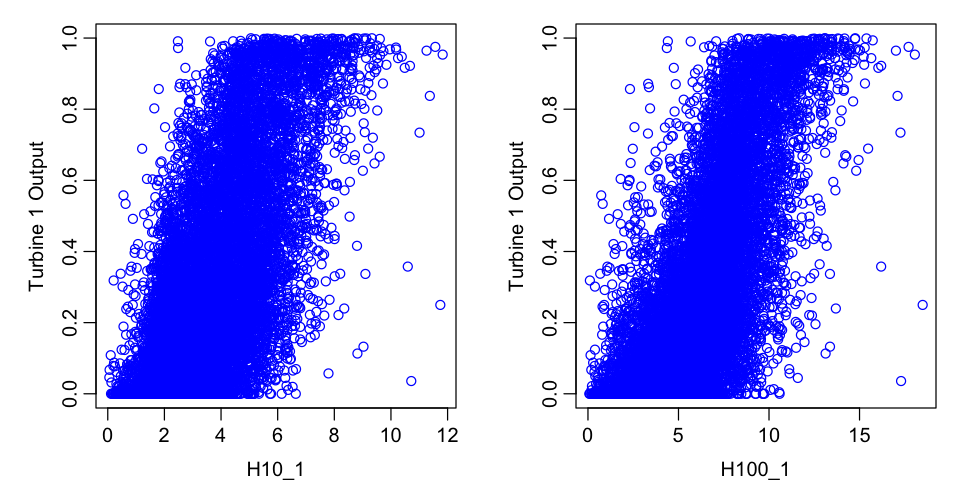

In [3]:
# Add columns with horizontal wind velocity magnitudes.
# Remove columns with velocity components.
# Keep only every iskip'th row (to reduce response variable autocorrelation).

iskip <- 1

U10label  <- paste(paste("U10",  rm, sep=""), 1:nturbines, sep="")
U100label <- paste(paste("U100", rm, sep=""), 1:nturbines, sep="")
V10label  <- paste(paste("V10",  rm, sep=""), 1:nturbines, sep="")
V100label <- paste(paste("V100", rm, sep=""), 1:nturbines, sep="")
H10label  <- paste(paste("H10",  rm, sep=""), 1:nturbines, sep="")
H100label <- paste(paste("H100", rm, sep=""), 1:nturbines, sep="")
for (i in wind_measurements) {
    df[[H10label[i]]]  <- sqrt(df[[U10label[i]]]**2  + df[[V10label[i]]]**2)
    df[[H100label[i]]] <- sqrt(df[[U100label[i]]]**2 + df[[V100label[i]]]**2)
    df[[U10label[i]]]  <- NULL
    df[[U100label[i]]] <- NULL
    df[[V10label[i]]]  <- NULL
    df[[V100label[i]]] <- NULL
}
df <- df[seq(iskip, to=nrow(df), by=iskip), ]
cat("\nData frame dimensions: ", dim(df)[1], " rows, ", dim(df)[2], " columns", sep="")
options(repr.plot.width=8, repr.plot.height=4)
par(mgp=c(2, 0.6, 0), mar=c(3,4,1,1), mfrow=c(1, 2))
plot(TARGETVAR_1 ~ df[[H10label[1]]],  data=df, col="blue", xlab=H10label[1],  ylab="Turbine 1 Output")
plot(TARGETVAR_1 ~ df[[H100label[1]]], data=df, col="blue", xlab=H100label[1], ylab="Turbine 1 Output")

<a id='Cell4'></a>


Autocorrelation in turbine outputs:  0.9427811
Correlation between turbine output and wind speed:  0.6939795

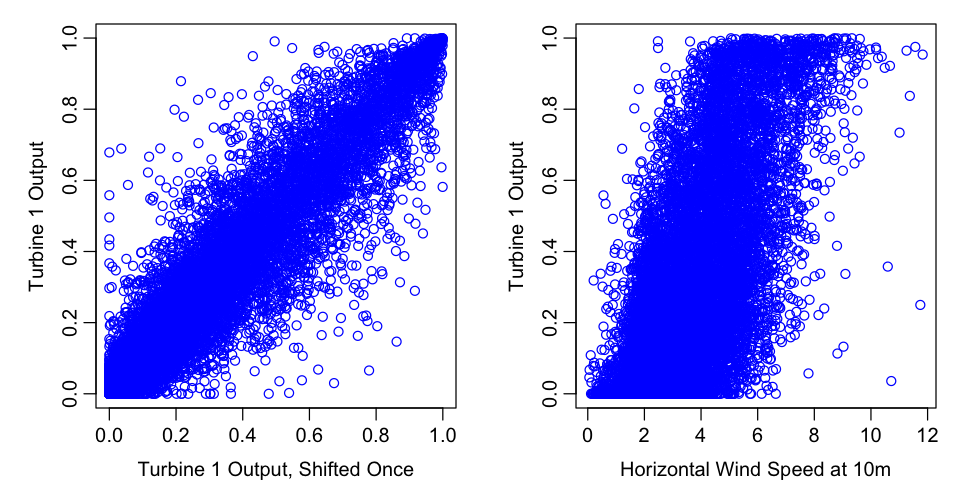

In [4]:
# Examine autocorrelations in turbine output measurements.

shift.down <- function(x, n) {c(x[-(seq(n))], rep(NA, n))}

dfc <- data.frame(TARGETVAR_1=df$TARGETVAR_1, TARGETVAR_1S=df$TARGETVAR_1, H10=df[[H10label[1]]])
dfc$TARGETVAR_1S <- shift.down(dfc$TARGETVAR_1S, 1)

options(repr.plot.width=8, repr.plot.height=4)
par(mgp=c(2, 0.6, 0), mar=c(3,4,1,1), mfrow=c(1, 2))
plot(TARGETVAR_1 ~ TARGETVAR_1S, data=dfc, col="blue", 
     xlab="Turbine 1 Output, Shifted Once", ylab="Turbine 1 Output")
plot(TARGETVAR_1 ~ H10, data=dfc, col="blue", 
     xlab="Horizontal Wind Speed at 10m", ylab="Turbine 1 Output")

cat("\nAutocorrelation in turbine outputs: ", 
    cor(dfc$TARGETVAR_1, dfc$TARGETVAR_1S, use="pairwise.complete.obs"))
cat("\nCorrelation between turbine output and wind speed: ", 
    cor(dfc$TARGETVAR_1, dfc$H10, use="pairwise.complete.obs"))

<a id='Cell5'></a>

In [5]:
# Create new data frames, one per turbine output;
# If desired, remove rows where the turbine output is 0 or 1;
# Split each data frame into a training and a testing data frame.

remove01 <- FALSE

predictors <- colnames(df)[-c(1:10)]
fdf        <- vector("list", nturbines)
fdf_train  <- vector("list", nturbines)
fdf_test   <- vector("list", nturbines)
for (i in 1:nturbines) {
    target         <- paste("TARGETVAR_", i, sep="")
    fdf[[i]]       <- df[, c(target,predictors)]
    if (remove01) {
        fdf[[i]]   <- fdf[[i]][fdf[[i]][[target]]!=0 & fdf[[i]][[target]]!=1,]
    }
    set.seed(7)
    indices        <- sample(1:nrow(fdf[[i]]), size=0.30*nrow(fdf[[i]]))
    fdf_test[[i]]  <- fdf[[i]][indices,]
    fdf_train[[i]] <- fdf[[i]][-indices,]
    cat("\nData frame ", i," dimensions: (", dim(fdf[[i]])[1], ", ", dim(fdf[[i]])[2], 
        ");  train: (", dim(fdf_train[[i]])[1], ", ", dim(fdf_train[[i]])[2], 
        ");  test: (", dim(fdf_test[[i]])[1], ", ", dim(fdf_test[[i]])[2], ").", sep="")
}
names(fdf)       <- paste("fdf", 1:nturbines, sep="")
names(fdf_train) <- paste("fdf", 1:nturbines, sep="")
names(fdf_test)  <- paste("fdf", 1:nturbines, sep="")


Data frame 1 dimensions: (13871, 20);  train: (9710, 20);  test: (4161, 20).
Data frame 2 dimensions: (13871, 20);  train: (9710, 20);  test: (4161, 20).
Data frame 3 dimensions: (13871, 20);  train: (9710, 20);  test: (4161, 20).
Data frame 4 dimensions: (13871, 20);  train: (9710, 20);  test: (4161, 20).
Data frame 5 dimensions: (13871, 20);  train: (9710, 20);  test: (4161, 20).
Data frame 6 dimensions: (13871, 20);  train: (9710, 20);  test: (4161, 20).
Data frame 7 dimensions: (13871, 20);  train: (9710, 20);  test: (4161, 20).
Data frame 8 dimensions: (13871, 20);  train: (9710, 20);  test: (4161, 20).
Data frame 9 dimensions: (13871, 20);  train: (9710, 20);  test: (4161, 20).
Data frame 10 dimensions: (13871, 20);  train: (9710, 20);  test: (4161, 20).

<a id='Cell6'></a>

In [6]:
# Fit training data frames.
# This version does not check which predictors are significant.

linear_predictor <- paste(H10label[wind_measurements], H100label[wind_measurements], sep=" + ", collapse=" + " )
wtp              <- vector("list", nturbines)
for (i in 1:nturbines) {
    target   <- paste("TARGETVAR_", i, sep="")
    fmla     <- as.formula(paste(target, " ~ ", linear_predictor, sep=""))
    wtp[[i]] <- gamlss(fmla, data=fdf_train[[i]], family=BEINF, method=mixed(), trace=FALSE)
}

<a id='Cell7'></a>

In [114]:
# Fit training data frames.
# This version checks for predictors that are not significant and eliminates them one by one.

wtp <- vector("list", nturbines)
for (i in 1:nturbines) {
    all_predictors <- c(H10label[wind_measurements], H100label[wind_measurements])
    target         <- paste("TARGETVAR_", i, sep="")
    more           <- TRUE
    while (more) {
        linear_predictor <- paste(all_predictors, sep=" + ", collapse=" + " )        
        fmla             <- as.formula(paste(target, " ~ ", linear_predictor, sep=""))
        wtp[[i]]         <- gamlss(fmla, data=fdf_train[[i]], family=BEINF, method=mixed(), trace=FALSE)
        swtp             <- summarynoprint.gamlss(wtp[[i]])
        deviance0        <- wtp[[i]]$G.deviance
        all_predictors   <- names(swtp$mu.coef.table[,4])
        all_predictors   <- all_predictors[all_predictors != "(Intercept)"]
        
        # Make a list of "bad" predictors, i.e. predictors with a p-value>5%.
        n_bad_predictors <- 0
        bad_predictors   <- vector("integer", length(all_predictors))
        for (name in all_predictors) {
            if (swtp$mu.coef.table[,4][[name]] >= 0.05) {
                n_bad_predictors                 <- n_bad_predictors + 1
                bad_predictors[n_bad_predictors] <- name
            }
        }
        
        # Loop over all bad predictors, find the one whose removal results in the smallest change in deviance.
        if (n_bad_predictors == 0) {
            more <- FALSE
        } else {
            delta_deviances  <- vector("double", n_bad_predictors)
            for (j in 1:n_bad_predictors) {
                new_predictors     <- all_predictors[all_predictors != bad_predictors[j]]
                linear_predictor   <- paste(new_predictors, sep=" + ", collapse=" + " )        
                fmla               <- as.formula(paste(target, " ~ ", linear_predictor, sep=""))
                wtp[[i]]           <- gamlss(fmla, data=fdf_train[[i]], family=BEINF, method=mixed(), trace=FALSE)
                delta_deviances[j] <- wtp[[i]]$G.deviance - deviance0
            }
            index_sm_dev   <- which.min(delta_deviances)
            all_predictors <- all_predictors[all_predictors != bad_predictors[index_sm_dev]]
            if (length(all_predictors) == 0) {more <- FALSE}
        }
    }
    cat("\nTurbine ", i, ": Number of predictors = ", length(all_predictors), ", deviance = ", deviance0, sep="")
    cat("\n           Predictors:", all_predictors, "\n", sep=" ")
}


Turbine 1: Number of predictors = 7, deviance = -32055.43
           Predictors: H10_rm3_4 H10_rm3_6 H10_rm3_7 H10_rm3_9 H100_rm3_2 H100_rm3_4 H100_rm3_7 

Turbine 2: Number of predictors = 8, deviance = -34776.77
           Predictors: H10_rm3_2 H10_rm3_3 H10_rm3_4 H10_rm3_6 H10_rm3_10 H100_rm3_2 H100_rm3_3 H100_rm3_10 

Turbine 3: Number of predictors = 6, deviance = -32570.67
           Predictors: H10_rm3_1 H10_rm3_9 H10_rm3_10 H100_rm3_1 H100_rm3_3 H100_rm3_10 

Turbine 4: Number of predictors = 4, deviance = -27551.09
           Predictors: H10_rm3_4 H10_rm3_10 H100_rm3_1 H100_rm3_6 

Turbine 5: Number of predictors = 8, deviance = -30008.23
           Predictors: H10_rm3_1 H10_rm3_2 H100_rm3_1 H100_rm3_2 H100_rm3_4 H100_rm3_6 H100_rm3_7 H100_rm3_10 

Turbine 6: Number of predictors = 8, deviance = -29549.21
           Predictors: H10_rm3_4 H10_rm3_10 H100_rm3_1 H100_rm3_2 H100_rm3_4 H100_rm3_6 H100_rm3_7 H100_rm3_10 

Turbine 7: Number of predictors = 5, deviance = -34177.4
   

<a id='Cell8'></a>

In [7]:
# Compute root mean squared errors on training and testing data sets.

rmse_train <- vector("double", nturbines)
rmse_test  <- vector("double", nturbines)
for (i in 1:nturbines) {
    target        <- paste("TARGETVAR_", i, sep="")
    y_train_pred  <- predict(wtp[[i]], what="mu", newdata=NULL, type="response" )
    y_train_true  <- fdf_train[[i]][[target]]
    rmse_train[i] <- sum((y_train_pred-y_train_true)^2)/nrow(fdf_train[[i]])
    
    y_test_pred   <- predict(wtp[[i]], what="mu", newdata=fdf_test[[i]], type="response" )
    y_test_true   <- fdf_test[[i]][[target]]
    rmse_test[i]  <- sum((y_test_pred-y_test_true)^2)/nrow(fdf_test[[i]])
}
cat("\nRoot mean square errors on training data set:")
cat("\nBy turbine: ", sqrt(rmse_train), sep=" ")
cat("\nTotal: ", sqrt(sum(rmse_train)/nturbines))
cat("\n\nRoot mean square errors on testing data set:")
cat("\nBy turbine: ", sqrt(rmse_test), sep=" ")
cat("\nTotal: ", sqrt(sum(rmse_test)/nturbines))


Root mean square errors on training data set:
By turbine:  0.1414579 0.148689 0.1619508 0.1759163 0.1769235 0.1856007 0.140637 0.1643339 0.1640073 0.2032209
Total:  0.1673393

Root mean square errors on testing data set:
By turbine:  0.1409343 0.1498664 0.163179 0.1745539 0.1751415 0.1829371 0.1414099 0.1671427 0.1642875 0.1989947
Total:  0.166758

<a id='Cell9'></a>

In [10]:
# Print summary of fit results by turbine.

sumwtp <- summary(wtp[[1]], save=TRUE)

Warning message in summary.gamlss(wtp[[1]], save = TRUE):
“summary: vcov has failed, option qr is used instead
”

******************************************************************
Family:  c("BEINF", "Beta Inflated") 

Call:  gamlss(formula = fmla, family = BEINF, data = fdf_train[[i]],  
    method = mixed(), trace = FALSE) 

Fitting method: mixed() 

------------------------------------------------------------------
Mu link function:  logit
Mu Coefficients:
            Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -4.21296    0.03045 -138.354  < 2e-16 ***
H10_rm3_1   -0.08838    0.04786   -1.847 0.064844 .  
H100_rm3_1  -0.02852    0.03191   -0.894 0.371531    
H10_rm3_2   -0.05134    0.03133   -1.639 0.101344    
H100_rm3_2   0.03164    0.02116    1.496 0.134775    
H10_rm3_3    0.06174    0.02780    2.221 0.026362 *  
H100_rm3_3  -0.05129    0.01879   -2.730 0.006354 ** 
H10_rm3_4   -0.14702    0.04750   -3.095 0.001972 ** 
H100_rm3_4   0.13865    0.03627    3.823 0.000133 ***
H10_rm3_6    0.20436    0.05672    3.603 0.000316 ***
H100_rm3_6  -0.16046    0.04171   -3.847 0.000120 ***
H

<a id='Cell10'></a>

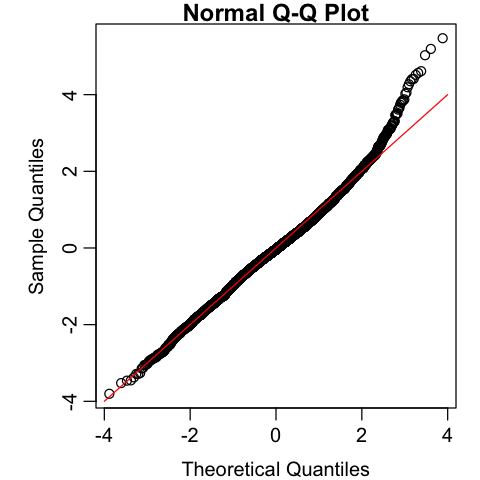

In [8]:
# Make a QQ plot.

options(repr.plot.width=4, repr.plot.height=4)
par(mgp=c(2, 0.6, 0), mar=c(3,4,1,1), mfrow=c(1, 1))
qqnorm(residuals(wtp[[1]])[is.finite(residuals(wtp[[1]]))])
lines(c(-4,4), c(-4,4), col="red")

<a id='Cell11'></a>

TARGETVAR_1 ~ H10_1 + H100_1 + H10_2 + H100_2 + H10_3 + H100_3 + 
    H10_4 + H100_4 + H10_6 + H100_6 + H10_7 + H100_7 + H10_9 + 
    H100_9 + H10_10 + H100_10

******************************************************************
	 Summary of the Randomised Quantile Residuals
                           mean   =  -0.02257782 
                       variance   =  0.9787504 
               coef. of skewness  =  0.2208773 
               coef. of kurtosis  =  3.94523 
Filliben correlation coefficient  =  0.996353 
******************************************************************


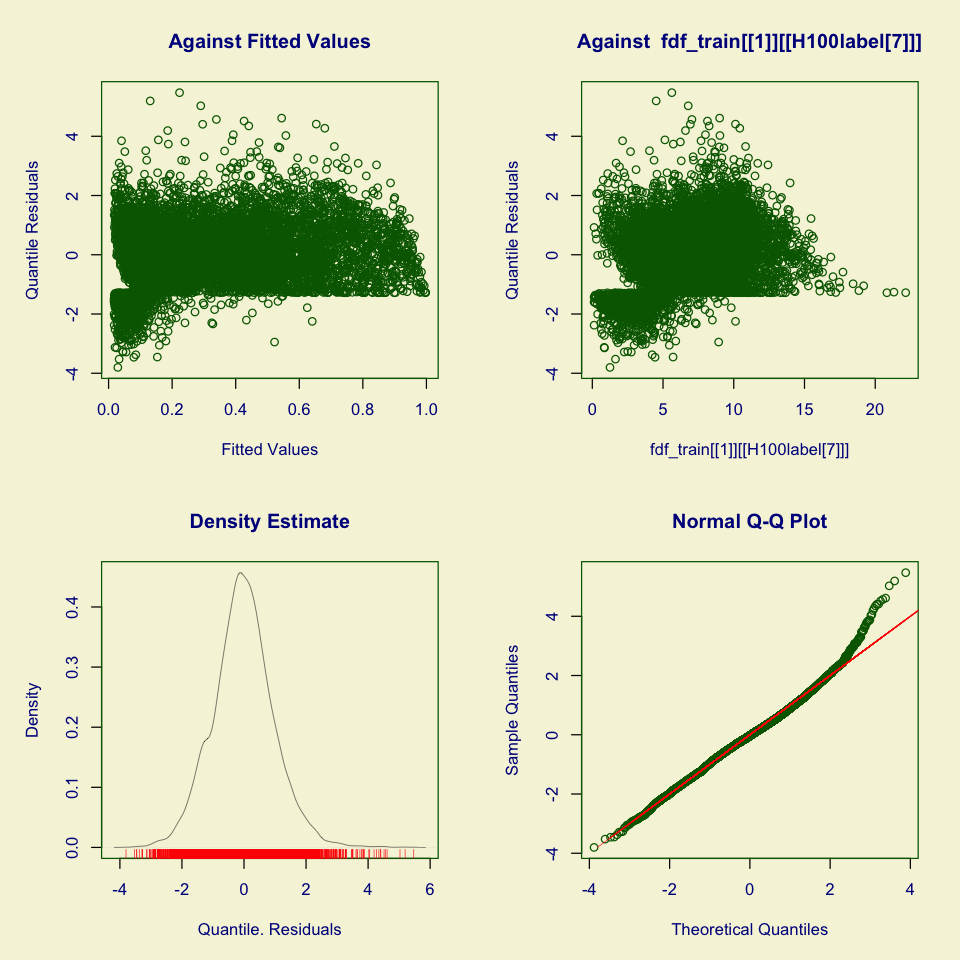

In [9]:
# Plot residuals.
formula(wtp[[1]])

options(repr.plot.width=8, repr.plot.height=8)
par(mgp=c(3,1,0), mar=c(5,4,4,2)+0.1, mfrow=c(2, 2))
plot(wtp[[1]], xvar=fdf_train[[1]][[H100label[7]]])

<a id='Cell12'></a>

Warning message in wp(wtp[[i]], data = fdf_train[[i]]):
“Some points are missed out 
increase the y limits using ylim.all”

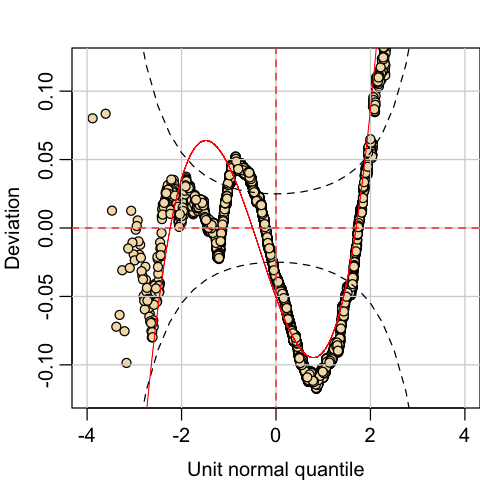

In [10]:
# Make a worm plot.

#wp(wtp[[1]], xvar=df_train$H10_rm3_1, n.inter=4)
options(repr.plot.width=4, repr.plot.height=4)
par(mgp=c(2, 0.6, 0), mar=c(3,3,2,0))
i <- 1
wp(wtp[[i]], data=fdf_train[[i]])

<a id='Cell13'></a>

In [50]:
# Fit entire training set.

wtp_full <- vector("list", nturbines)
for (i in 1:nturbines) {
    target        <- paste("TARGETVAR_", i, sep="")
    fmla          <- as.formula(paste(target, " ~ ", linear_predictor, sep=""))
    wtp_full[[i]] <- gamlss(fmla, data=fdf[[i]], family=BEINF, method=mixed(), trace=FALSE)
}

<a id='Cell14'></a>

In [7]:
# Fit entire training data set.
# This version checks for predictors that are not significant and eliminates them one by one.

wtp_full <- vector("list", nturbines)
for (i in 1:nturbines) {
    all_predictors <- c(H10label[wind_measurements], H100label[wind_measurements])
    target         <- paste("TARGETVAR_", i, sep="")
    more           <- TRUE
    while (more) {
        linear_predictor <- paste(all_predictors, sep=" + ", collapse=" + " )        
        fmla             <- as.formula(paste(target, " ~ ", linear_predictor, sep=""))
        wtp_full[[i]]    <- gamlss(fmla, data=fdf[[i]], family=BEINF, method=mixed(), trace=FALSE)
        swtp             <- summarynoprint.gamlss(wtp_full[[i]])
        deviance0        <- wtp_full[[i]]$G.deviance
        all_predictors   <- names(swtp$mu.coef.table[,4])
        all_predictors   <- all_predictors[all_predictors != "(Intercept)"]
        
        # Make a list of "bad" predictors, i.e. predictors with a p-value>5%.
        n_bad_predictors <- 0
        bad_predictors   <- vector("integer", length(all_predictors))
        for (name in all_predictors) {
            if (swtp$mu.coef.table[,4][[name]] >= 0.05) {
                n_bad_predictors                 <- n_bad_predictors + 1
                bad_predictors[n_bad_predictors] <- name
            }
        }
        
        # Loop over all bad predictors, find the one whose removal results in the smallest change in deviance.
        if (n_bad_predictors == 0) {
            more <- FALSE
        } else {
            delta_deviances  <- vector("double", n_bad_predictors)
            for (j in 1:n_bad_predictors) {
                new_predictors     <- all_predictors[all_predictors != bad_predictors[j]]
                linear_predictor   <- paste(new_predictors, sep=" + ", collapse=" + " )        
                fmla               <- as.formula(paste(target, " ~ ", linear_predictor, sep=""))
                wtp_full[[i]]      <- gamlss(fmla, data=fdf[[i]], family=BEINF, method=mixed(), trace=FALSE)
                delta_deviances[j] <- wtp_full[[i]]$G.deviance - deviance0
            }
            index_sm_dev   <- which.min(delta_deviances)
            all_predictors <- all_predictors[all_predictors != bad_predictors[index_sm_dev]]
            if (length(all_predictors) == 0) {more <- FALSE}
        }
    }
    cat("\nTurbine ", i, ": Number of predictors = ", length(all_predictors), ", deviance = ", deviance0, sep="")
    cat("\n           Predictors:", all_predictors, "\n", sep=" ")
}


Turbine 1: Number of predictors = 14, deviance = -10783.69
           Predictors: H10_rm3_2 H10_rm3_3 H10_rm3_4 H10_rm3_6 H10_rm3_7 H10_rm3_10 H100_rm3_1 H100_rm3_2 H100_rm3_3 H100_rm3_4 H100_rm3_6 H100_rm3_7 H100_rm3_9 H100_rm3_10 

Turbine 2: Number of predictors = 9, deviance = -16151.99
           Predictors: H10_rm3_2 H10_rm3_3 H10_rm3_4 H10_rm3_6 H100_rm3_1 H100_rm3_2 H100_rm3_3 H100_rm3_9 H100_rm3_10 

Turbine 3: Number of predictors = 14, deviance = -9541.216
           Predictors: H10_rm3_1 H10_rm3_2 H10_rm3_3 H10_rm3_4 H10_rm3_6 H10_rm3_9 H100_rm3_1 H100_rm3_2 H100_rm3_3 H100_rm3_4 H100_rm3_6 H100_rm3_7 H100_rm3_9 H100_rm3_10 

Turbine 4: Number of predictors = 11, deviance = -16318.16
           Predictors: H10_rm3_2 H10_rm3_6 H10_rm3_7 H10_rm3_9 H10_rm3_10 H100_rm3_1 H100_rm3_4 H100_rm3_6 H100_rm3_7 H100_rm3_9 H100_rm3_10 

Turbine 5: Number of predictors = 6, deviance = -7286.713
           Predictors: H10_rm3_10 H100_rm3_1 H100_rm3_2 H100_rm3_4 H100_rm3_6 H100_rm3_10 

T

<a id='Cell15'></a>

In [8]:
# Prepare the test data set in the same way as the training set, make predictions, and create output csv file.

# Load the testing data
if (rmws == 3) {
    df1 <- read_feather(path="data/Test_pp_2017_03_28_13_06_43.feather")
    rm  <- "_rm3_"
} else if (rmws <= 1) {
    df1 <- read_feather(path="data/Test_pp_2017_03_28_14_13_10.feather")
    rm  <- "_"
}
head(df1)
cat("\nData frame dimensions: ", dim(df1)[1], " rows, ", dim(df1)[2], " columns", sep="")

# Count how many sets of observations we have in August and September 2013
nTotal      <- dim(df1)[1]
nAugSep2013 <- dim(df1[df1$DAYOFYEAR>212 & df1$DAYOFYEAR<274,])[1]
cat("\nTotal number of observation times in test set:            ", nTotal)
cat("\nNumber of observation times in August and September 2013: ", nAugSep2013)

# Compute horizontal wind speeds
for (i in wind_measurements) {
    df1[[H10label[i]]]  <- sqrt(df1[[U10label[i]]]**2  + df1[[V10label[i]]]**2)
    df1[[H100label[i]]] <- sqrt(df1[[U100label[i]]]**2 + df1[[V100label[i]]]**2)
    df1[[U10label[i]]]  <- NULL
    df1[[U100label[i]]] <- NULL
    df1[[V10label[i]]]  <- NULL
    df1[[V100label[i]]] <- NULL
}
cat("\nData frame dimensions: ", dim(df1)[1], " rows, ", dim(df1)[2], " columns", sep="")

# Create new data frames, one per turbine output; for the purpose of computing predictions 
# next, the ID column of each fdf1 data frame must be renamed TARGETVAR
predictors <- colnames(df1)[-c(1:10)]
fdf1       <- vector("list", nturbines)
for (i in 1:nturbines) {
    turbid    <- paste("ID_", i, sep="")
    target    <- paste("TARGETVAR_", i, sep="")
    fdf1[[i]] <- df1[, c(turbid,predictors)]
    colnames(fdf1[[i]])[1] <- target
}

# Compute predictions
npts            <- dim(df1)[1]
df1_ids         <- vector("integer", nturbines*npts)
df1_predictions <- vector("double", nturbines*npts)
for (i in 1:nturbines) {
    target                                   <- paste("TARGETVAR_", i, sep="")
    df1_ids[((i-1)*npts+1):(i*npts)]         <- fdf1[[i]][[target]]
    df1_predictions[((i-1)*npts+1):(i*npts)] <- predict(wtp_full[[i]], what="mu", newdata=fdf1[[i]], 
                                                        type="response")
}

# Generate output csv file
df1_out   <- data.frame(ID=df1_ids, TARGETVAR=df1_predictions)
fName_out <- paste("data/gamr_", strftime(Sys.time(), "%Y_%m_%d_%H_%M_%S"), ".out.csv", sep="")
write.csv(df1_out, fName_out, row.names=FALSE)
cat("\nOutput written to ", fName_out)

Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”Warning message:
“Coercing int64 to double”

ID_1,ID_2,ID_3,ID_4,ID_5,ID_6,ID_7,ID_8,ID_9,ID_10,⋯,U100_rm3_9,V10_rm3_9,V100_rm3_9,U10_rm3_10,U100_rm3_10,V10_rm3_10,V100_rm3_10,YEAR,DAYOFYEAR,HOUR
30010001,30010002,30010003,30010004,30010005,30010006,30010007,30010008,30010009,30010010,⋯,1.473541,-3.757118,-5.748985,-0.16511743,0.32084319,-2.658255,-4.277716,2013,213,0
30010101,30010102,30010103,30010104,30010105,30010106,30010107,30010108,30010109,30010110,⋯,2.425901,-3.923264,-5.798490,-0.25710303,-0.01486634,-3.223966,-4.800565,2013,213,1
30010201,30010202,30010203,30010204,30010205,30010206,30010207,30010208,30010209,30010210,⋯,2.899162,-4.043484,-5.885207,0.08507497,0.33025657,-3.693685,-5.259272,2013,213,2
30010301,30010302,30010303,30010304,30010305,30010306,30010307,30010308,30010309,30010310,⋯,3.475966,-4.194771,-5.943312,0.76474355,1.04894230,-4.490173,-6.070175,2013,213,3
30010401,30010402,30010403,30010404,30010405,30010406,30010407,30010408,30010409,30010410,⋯,3.356855,-4.239347,-5.972145,1.67993049,2.23944251,-4.925310,-6.571012,2013,213,4
30010501,30010502,30010503,30010504,30010505,30010506,30010507,30010508,30010509,30010510,⋯,3.043711,-4.216150,-5.947043,2.19111256,2.94371222,-4.988191,-6.673961,2013,213,5



Data frame dimensions: 2929 rows, 45 columns
Total number of observation times in test set:             2929
Number of observation times in August and September 2013:  1464
Data frame dimensions: 2929 rows, 29 columns
Output written to  data/gamr_2017_03_28_17_38_19.out.csv